Links:
- https://github.com/hardmaru/WorldModelsExperiments
- http://blog.otoro.net//2018/06/09/world-models-experiments/


In [4]:
%matplotlib inline
# notebook stuff
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

# numpy
import numpy as np
from PIL import Image

# torch stuff
import torch
import torch.nn as nn
from torchvision.transforms import Compose, ToTensor, ToPILImage
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from torchsummary import summary

# our stuff
import constants

import importlib
import model.vaelin
VAELin = importlib.reload(model.vaelin).VAELin
from dataset import VAEDataset

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0

In [6]:
all_data = VAEDataset(size=100000, transform=ToTensor())

In [7]:
def get_full_dataset(dataset):
    return torch.stack([dataset[i] for i in range(len(dataset))])

In [8]:
full_data = get_full_dataset(all_data)

In [9]:
def get_sample_weights(data):
    # preprocess dataset to inverted grayscale

    norm_dataset = (1-(data.sum(1)/3)).numpy()
    # get peaks of pixel distributions
    norm_px_dist = norm_dataset.sum(1)
    peaks = np.argmax(norm_px_dist, axis=1)
    #counts of peaks at x coordinates
    counts = np.bincount(peaks)

    # we invert the counts, normalize, and take softmax so low counts have high prob and high counts have low prob
    # norm_inv_counts = (-counts + counts.mean())/(counts.max() - counts.mean())
    # samp_prob = np.exp(norm_inv_counts)/np.exp(norm_inv_counts).sum())

    # replace each sample's peak with the count class of that peak
    counts_by_peaks = counts[peaks]
    # same as above except instead of a sample prob across counts
    # it's a sample prob across samples weighted by its count class
    norm_inv_counts_by_peaks = (-counts_by_peaks + counts_by_peaks.mean())/(counts_by_peaks.max() - counts_by_peaks.mean())
    samp_prob_by_peaks = np.exp(norm_inv_counts_by_peaks)/np.exp(norm_inv_counts_by_peaks).sum()

    return samp_prob_by_peaks


In [10]:
def get_peaks(data):
    norm_dataset = (1-(data.sum(1)/3)).numpy()
    # get peaks of pixel distributions
    norm_px_dist = norm_dataset.sum(1)
    peaks = np.argmax(norm_px_dist, axis=1)
    return peaks

In [11]:
sample_weights = get_sample_weights(full_data)

In [15]:
sampler = WeightedRandomSampler(sample_weights, num_samples=10000, replacement=True)

In [16]:
batch_size=32
train_loader = DataLoader(all_data, batch_size=batch_size, sampler=sampler, num_workers=2)

In [17]:
# model = VAE(conv_sizes=[4,8,16,32], device=device).to(device)
model = VAELin(z_size=32, device=device).to(device)

summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Reshape-1                [-1, 12288]               0
            Linear-2                  [-1, 400]       4,915,600
              ReLU-3                  [-1, 400]               0
            Linear-4                   [-1, 32]          12,832
            Linear-5                   [-1, 32]          12,832
            Linear-6                  [-1, 400]          13,200
              ReLU-7                  [-1, 400]               0
            Linear-8                [-1, 12288]       4,927,488
           Reshape-9            [-1, 3, 64, 64]               0
          Sigmoid-10            [-1, 3, 64, 64]               0
Total params: 9,881,952
Trainable params: 9,881,952
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.39
Params size (MB): 37.70
Estima

In [18]:
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
num_epochs = 40

In [29]:
for epoch in range(num_epochs):
    with tqdm(enumerate(train_loader), total=train_iter) as progress:
        for batch_idx, train_batch in progress:
            train_batch = train_batch.to(device)
            optimizer.zero_grad()
            original, decoded, encoded, z, mu, logvar = model.forward(train_batch)
            
            loss, _, _ = model.loss(original, decoded, mu, logvar)
            losses.append(loss.detach().cpu().numpy())
            loss.backward()
            optimizer.step()
            progress.set_postfix(avg_loss=sum(losses[-(batch_idx+1):])/(batch_idx+1))

In [30]:
np_losses = np.array(losses)

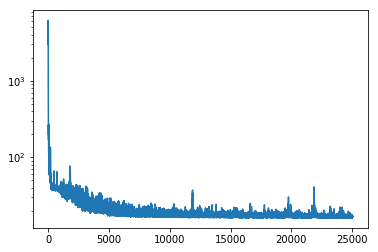

In [31]:
plt.semilogy(np_losses)

In [32]:
model.loss(original, decoded, mu, logvar)

(tensor(16.4933, device='cuda:0', grad_fn=<ThAddBackward>),
 tensor(16., device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(0.4933, device='cuda:0', grad_fn=<MeanBackward1>))

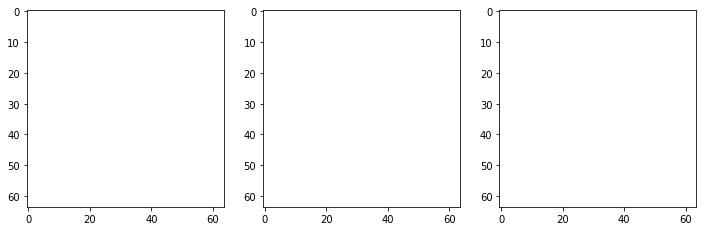

In [34]:
fig = plt.figure(figsize=(12,5))
ims = []
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
for i in range(1000):
    temp = all_data[i].cuda(device).reshape((1, 3, 64, 64))
    inim = temp[0].detach().cpu().numpy().transpose((1,2,0))
    outim = model.forward(temp)[1][0].detach().cpu().numpy().transpose((1,2,0))
    im1 = ax1.imshow(np.abs(inim), animated=True)
    im2 = ax2.imshow(np.abs(outim-inim), animated=True)
    im3 = ax3.imshow(np.abs(outim), animated=True)
    ims.append([im1, im2, im3])
anim = animation.ArtistAnimation(fig, ims, interval=20, blit=True)

In [36]:
vid = anim.to_html5_video()

In [37]:
HTML(vid)

0


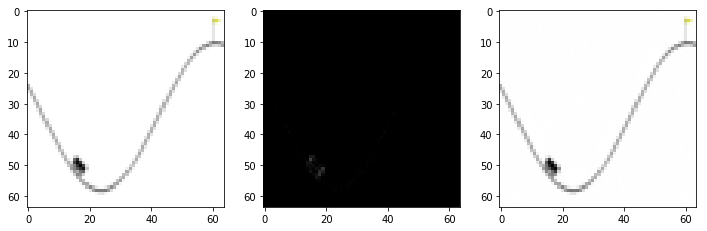

1


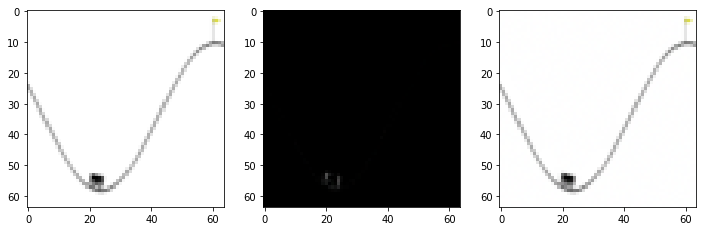

2


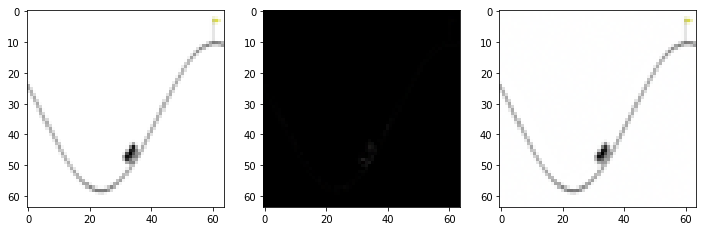

3


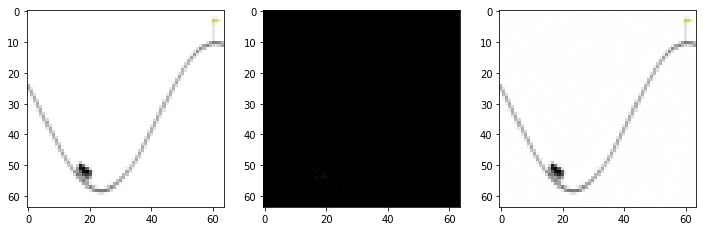

4


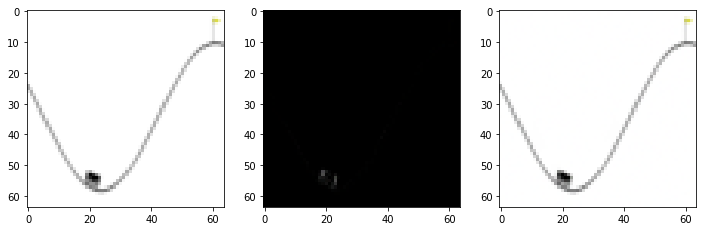

5


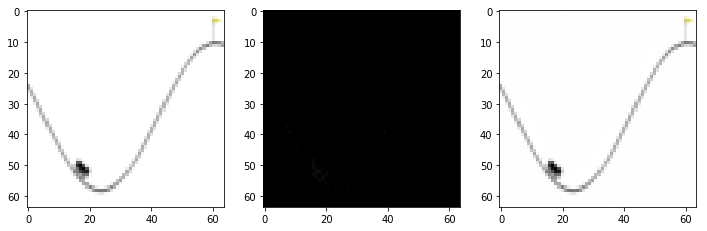

6


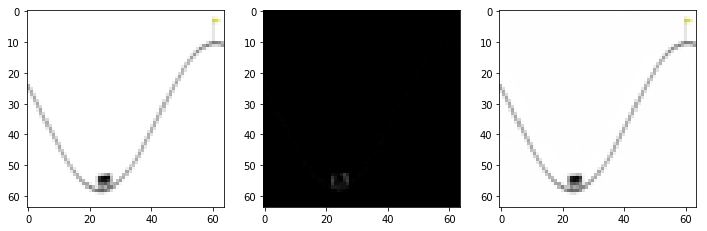

7


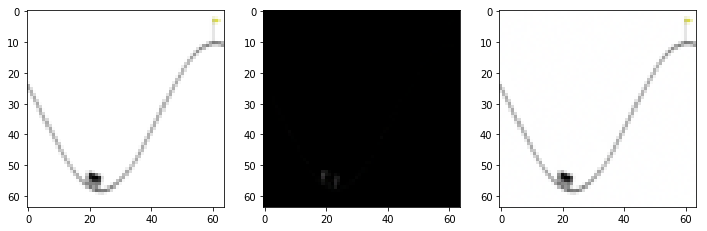

8


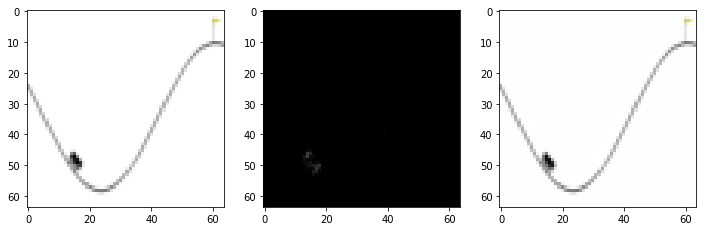

9


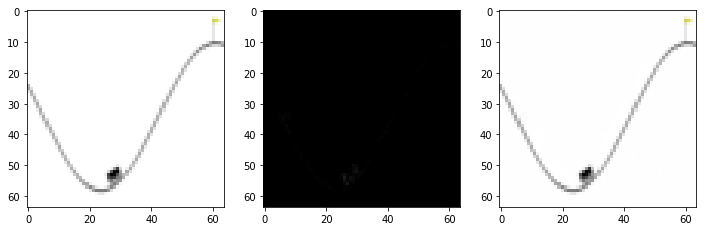

10


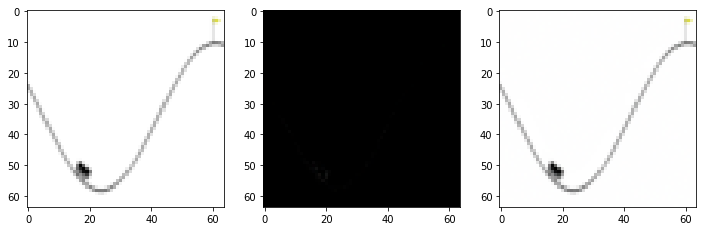

11


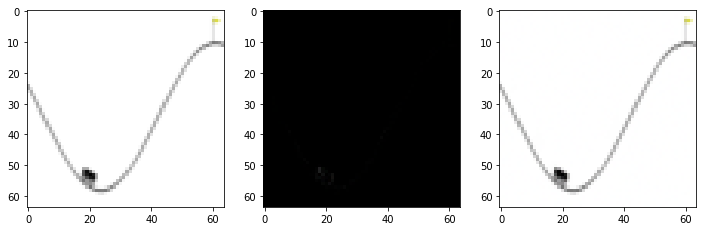

12


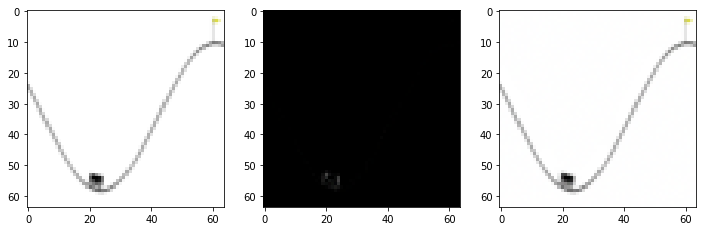

13


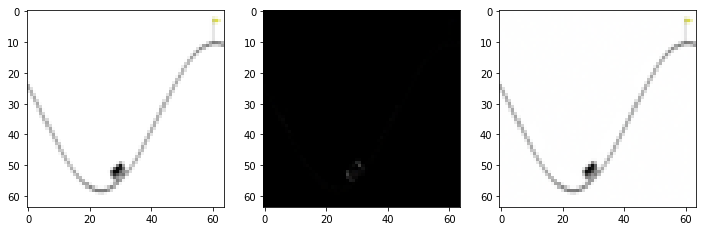

14


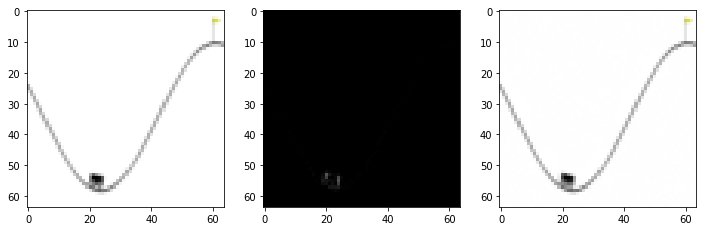

15


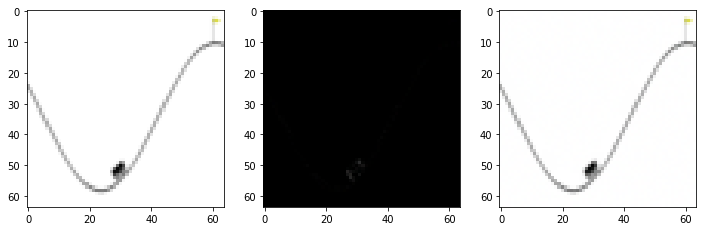

16


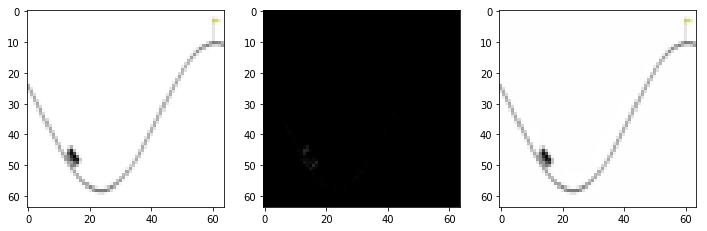

17


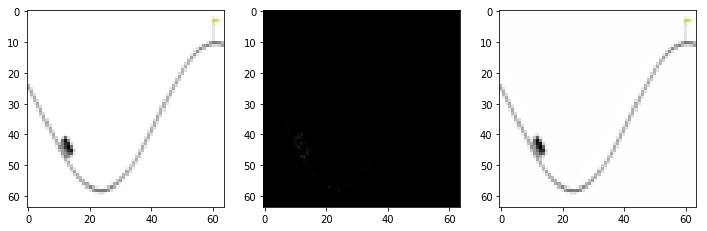

18


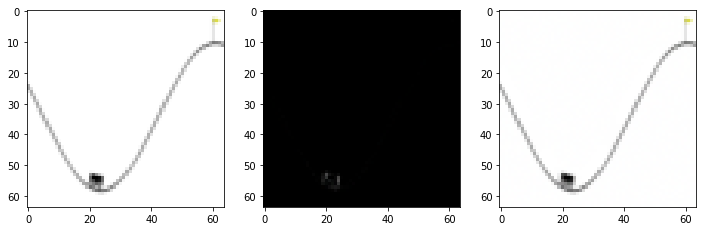

19


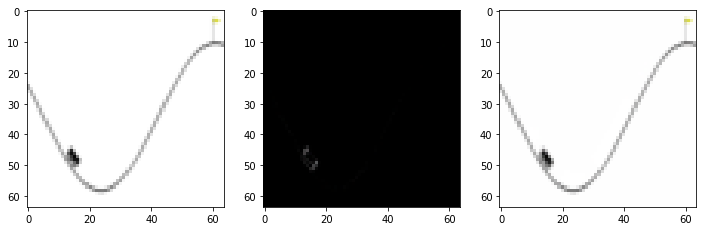

20


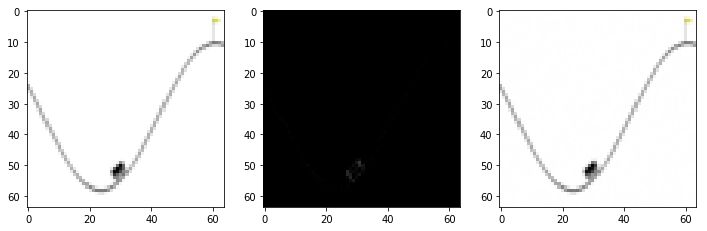

21


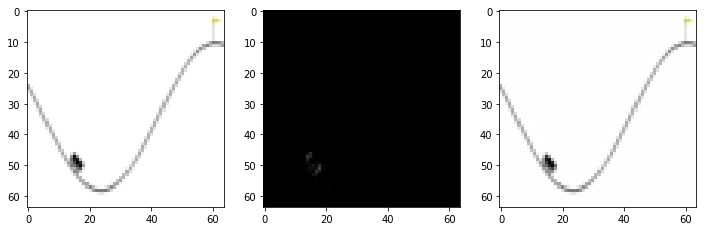

22


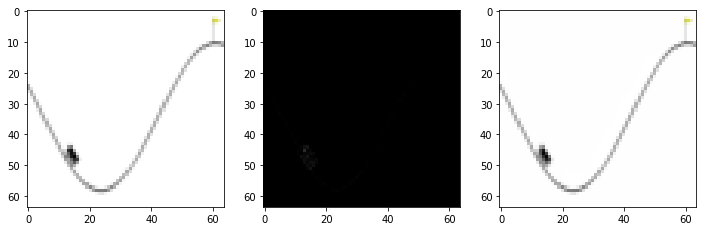

23


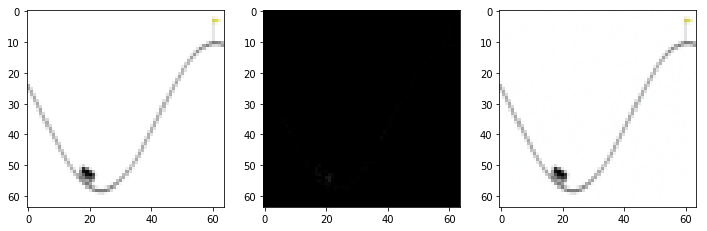

24


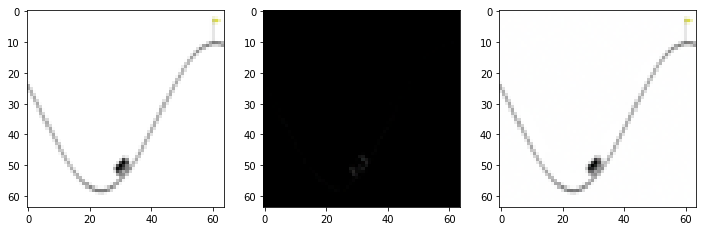

25


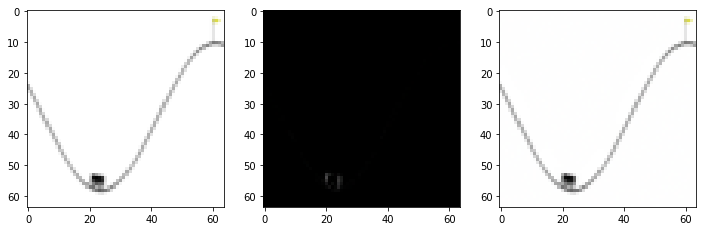

26


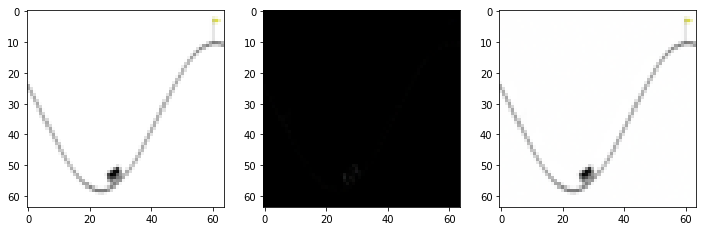

27


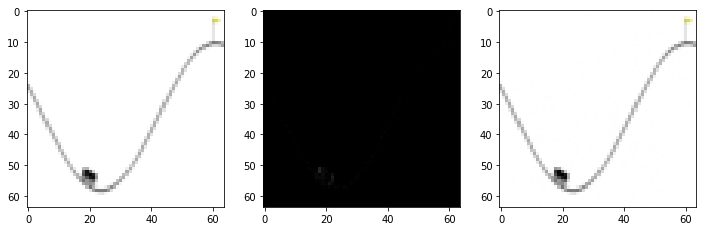

28


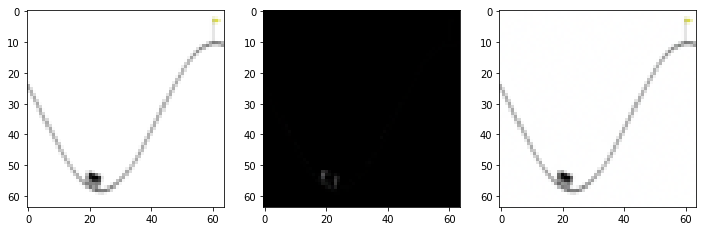

29


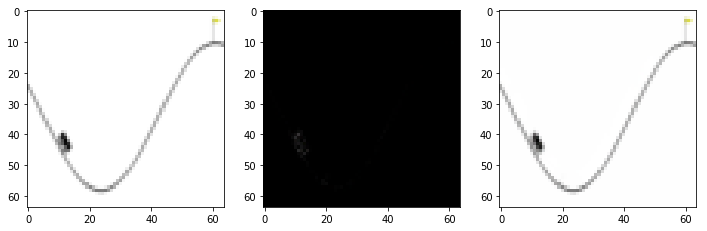

30


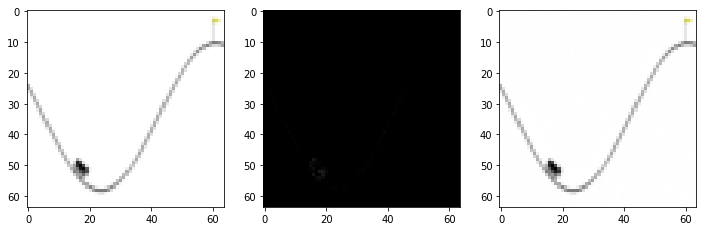

31


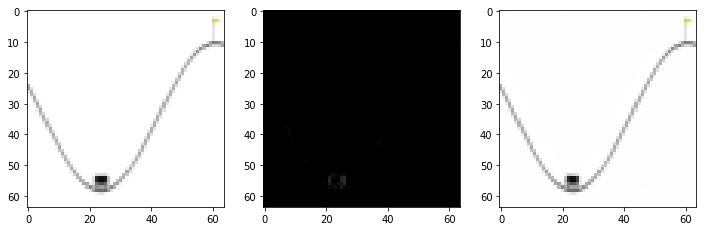

In [35]:

for batch_idx, train_batch in enumerate(train_loader):
    if batch_idx < 2:
        continue
    if batch_idx > 2:
        break
    for i in range(batch_size):
        temp = train_batch[i].cuda(device).reshape((1, 3, 64, 64))
        inim = temp[0].detach().cpu().numpy().transpose((1,2,0))
        outim = model.forward(temp)[1][0].detach().cpu().numpy().transpose((1,2,0))
        print(i)
        plt.figure(figsize=(12,5))
        plt.subplot(1,3,1)
        plt.imshow(np.abs(inim))
        plt.subplot(1,3,2)
        plt.imshow(np.abs(outim-inim))
        plt.subplot(1,3,3)
        plt.imshow(np.abs(outim))
        plt.show()
